In [1]:
!pip install statsmodels
!pip install pmdarima

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import files
uploaded = files.upload()

Saving MTA_Bus_Hourly_Ridership__2020-2024_20250420.csv to MTA_Bus_Hourly_Ridership__2020-2024_20250420.csv


In [3]:
import io
df = pd.read_csv(io.BytesIO(uploaded['MTA_Bus_Hourly_Ridership__2020-2024_20250420.csv']))

print(df.shape)
df.head()

(1823616, 6)


,transit_timestamp,bus_route,payment_method,fare_class_category,ridership,transfers
0,06/14/2023 12:00:00 AM,Q52+,omny,OMNY - Other,0,0
1,06/14/2023 04:00:00 AM,Q52+,metrocard,OMNY - Seniors & Disability,0,0
2,06/14/2023 07:00:00 PM,Q52+,metrocard,Metrocard - Fair Fare,8,1
3,06/14/2023 02:00:00 PM,Q52+,omny,Metrocard - Seniors & Disability,0,0
4,06/14/2023 10:00:00 PM,Q52+,omny,Metrocard - Students,0,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1823616 entries, 0 to 1823615
Data columns (total 6 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   transit_timestamp    object
 1   bus_route            object
 2   payment_method       object
 3   fare_class_category  object
 4   ridership            int64 
 5   transfers            int64 
dtypes: int64(2), object(4)
memory usage: 83.5+ MB


In [9]:
df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'])
df['date'] = df['transit_timestamp'].dt.date

print(f"Date range: {df['date'].min()} to {df['date'].max()}")
df.head()

Date range: 2020-09-01 to 2024-12-31


,transit_timestamp,bus_route,payment_method,fare_class_category,ridership,transfers,date
0,2023-06-14 00:00:00,Q52+,omny,OMNY - Other,0,0,2023-06-14
1,2023-06-14 04:00:00,Q52+,metrocard,OMNY - Seniors & Disability,0,0,2023-06-14
2,2023-06-14 19:00:00,Q52+,metrocard,Metrocard - Fair Fare,8,1,2023-06-14
3,2023-06-14 14:00:00,Q52+,omny,Metrocard - Seniors & Disability,0,0,2023-06-14
4,2023-06-14 22:00:00,Q52+,omny,Metrocard - Students,0,0,2023-06-14


In [10]:
daily_ridership = df.groupby(['date', 'bus_route'])['ridership'].sum().reset_index()

daily_pivot = daily_ridership.pivot(index='date', columns='bus_route', values='ridership')

daily_pivot = daily_pivot.sort_index()
daily_pivot = daily_pivot.fillna(0)

daily_pivot.head()

bus_route,Q52+,Q53+
date,,
2020-09-01,1587,5931
2020-09-02,1693,6335
2020-09-03,1788,6606
2020-09-04,2110,7779
2020-09-05,1785,6652


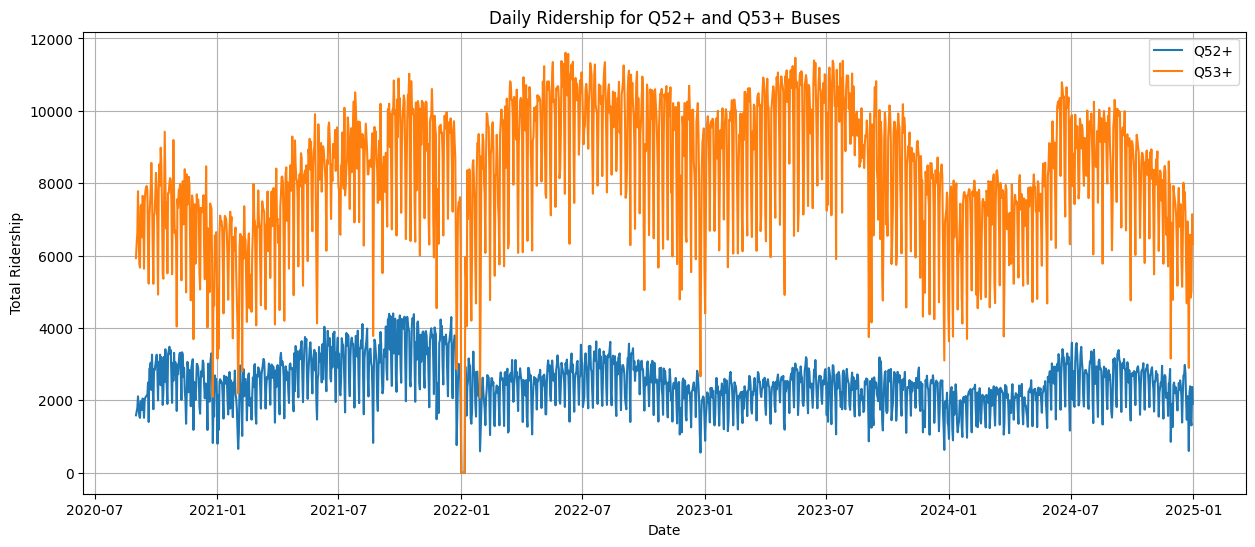

In [11]:
plt.figure(figsize=(15,6))
plt.plot(daily_pivot.index, daily_pivot['Q52+'], label='Q52+')
plt.plot(daily_pivot.index, daily_pivot['Q53+'], label='Q53+')
plt.title('Daily Ridership for Q52+ and Q53+ Buses')
plt.xlabel('Date')
plt.ylabel('Total Ridership')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
all_dates = pd.date_range(start=daily_pivot.index.min(), end=daily_pivot.index.max())

daily_pivot = daily_pivot.reindex(all_dates)
daily_pivot.index.name = 'date'
daily_pivot = daily_pivot.fillna(0)

print(f"Total days: {len(daily_pivot)}")
daily_pivot.head()

Total days: 1583


bus_route,Q52+,Q53+
date,,
2020-09-01,1587,5931
2020-09-02,1693,6335
2020-09-03,1788,6606
2020-09-04,2110,7779
2020-09-05,1785,6652


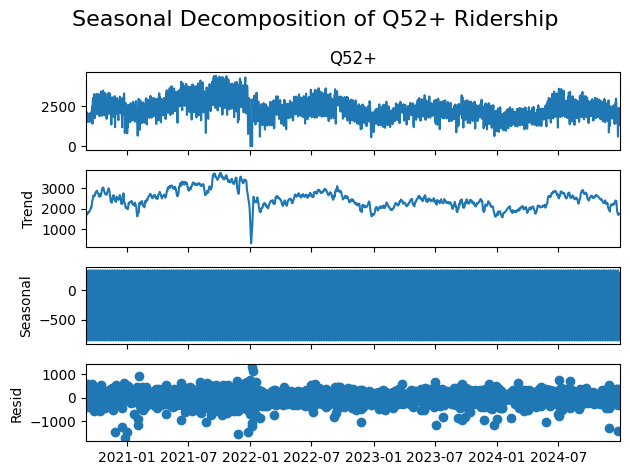

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose Q52+ series (we assume daily seasonality with weekly pattern = 7)
result_q52 = seasonal_decompose(daily_pivot['Q52+'], model='additive', period=7)

# Plot decomposition
result_q52.plot()
plt.suptitle("Seasonal Decomposition of Q52+ Ridership", fontsize=16)
plt.tight_layout()
plt.show()

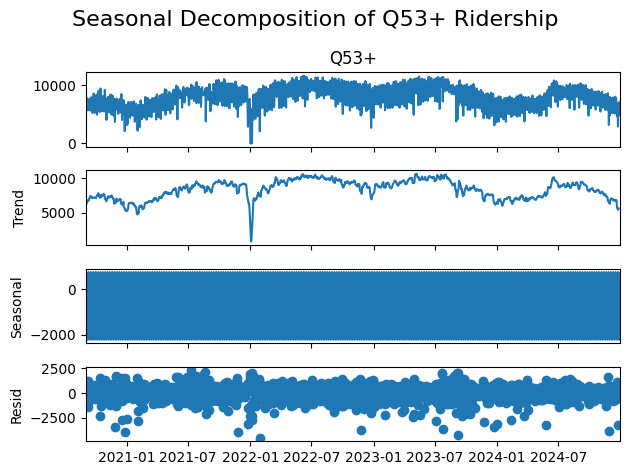

In [14]:
result_q53 = seasonal_decompose(daily_pivot['Q53+'], model='additive', period=7)

# Plot decomposition
result_q53.plot()
plt.suptitle("Seasonal Decomposition of Q53+ Ridership", fontsize=16)
plt.tight_layout()
plt.show()

In [15]:
def run_adf(series, label):
    result = adfuller(series)
    print(f'ADF Test for {label}')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    print('Stationary' if result[1] < 0.05 else 'Non-stationary')
    print('\n')

run_adf(daily_pivot['Q52+'], 'Q52+')
run_adf(daily_pivot['Q53+'], 'Q53+')

ADF Test for Q52+
ADF Statistic: -3.0239592417257524
p-value: 0.032716684184871045
Critical Values: {'1%': -3.4345460832553134, '5%': -2.863393317614214, '10%': -2.56775667487989}
Stationary


ADF Test for Q53+
ADF Statistic: -2.7076137529377937
p-value: 0.07272999861954374
Critical Values: {'1%': -3.4345487774977768, '5%': -2.8633945067663817, '10%': -2.5677573081032214}
Non-stationary




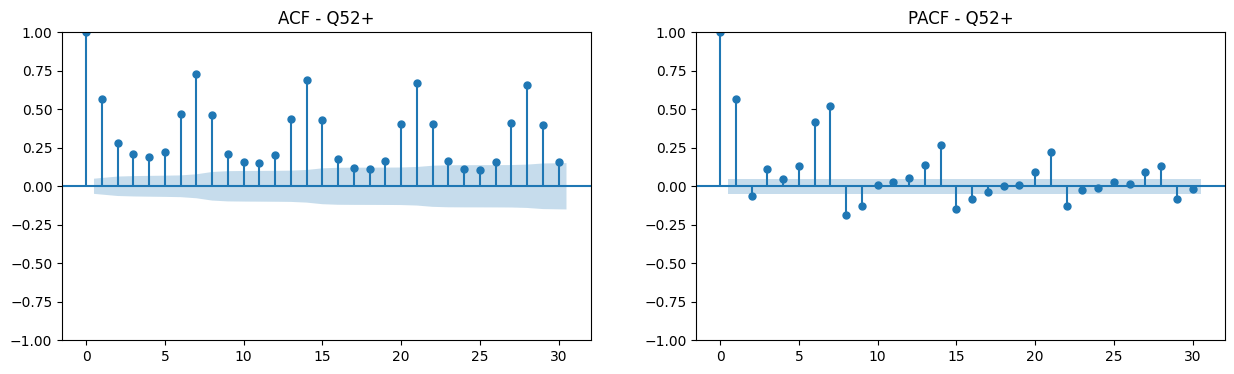

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))
plot_acf(daily_pivot['Q52+'], lags=30, ax=axes[0])
plot_pacf(daily_pivot['Q52+'], lags=30, ax=axes[1])
axes[0].set_title('ACF - Q52+')
axes[1].set_title('PACF - Q52+')
plt.show()

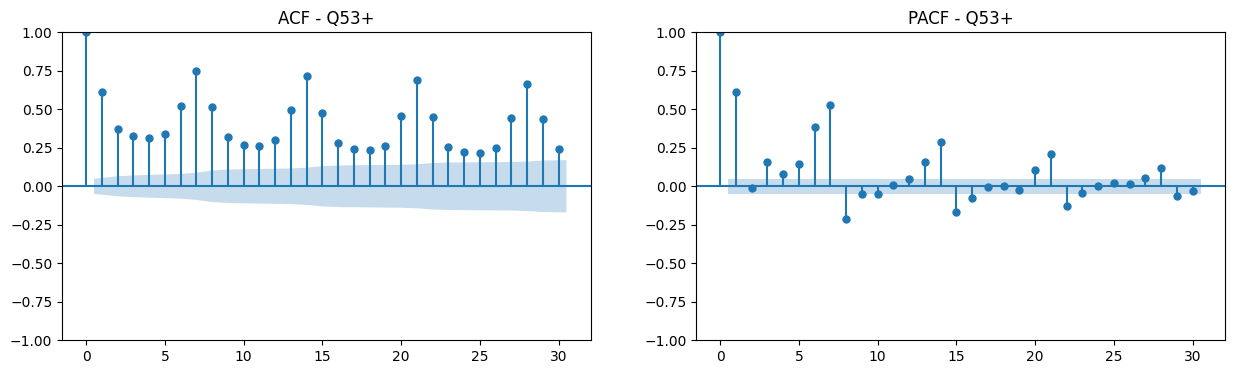

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))
plot_acf(daily_pivot['Q53+'], lags=30, ax=axes[0])
plot_pacf(daily_pivot['Q53+'], lags=30, ax=axes[1])
axes[0].set_title('ACF - Q53+')
axes[1].set_title('PACF - Q53+')
plt.show()

In [18]:
model_q52 = pm.auto_arima(daily_pivot['Q52+'],
                          seasonal=False,
                          trace=True,
                          stepwise=True,
                          suppress_warnings=True,
                          error_action='ignore')

model_q52.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=24247.695, Time=5.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=24924.438, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24881.951, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=24589.265, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=24922.438, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=24341.494, Time=1.77 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=24311.189, Time=1.90 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=5.33 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=23942.735, Time=4.97 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=24341.477, Time=3.23 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=6.87 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=23932.821, Time=16.17 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=24290.132, Time=9.84 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=23919.343, Time=5.18 sec
 ARIMA(4,1,4)(0,0,0)[0] interc

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1583
Model:               SARIMAX(5, 1, 2)   Log Likelihood              -11862.119
Date:                Wed, 30 Apr 2025   AIC                          23740.237
Time:                        03:45:28   BIC                          23783.169
Sample:                    09-01-2020   HQIC                         23756.188
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4438      0.019     23.201      0.000       0.406       0.481
ar.L2         -0.7333      0.023    -32.389      0.000      -0.778      -0.689
ar.L3         -0.2011      0.027     -7.409      0.000      -0.254      -0.148
ar.L4         -0.3357      0.023    -14.885      0.000      -0.380      -0.291
ar.L5         -0.3149      0.021    -14.692      0.000      -0.357      -0.273
ma.L1         -1.1461      0.012    -92.893      0.000      -1.170      -1.122
ma.L2          0.8928      0.011     82.873      0.000       0.872       0.914
sigma2      1.854e+05   4130.629     44.891      0.000    1.77e+05    1.94e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.35   Jarque-Bera (JB):              1205.52
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

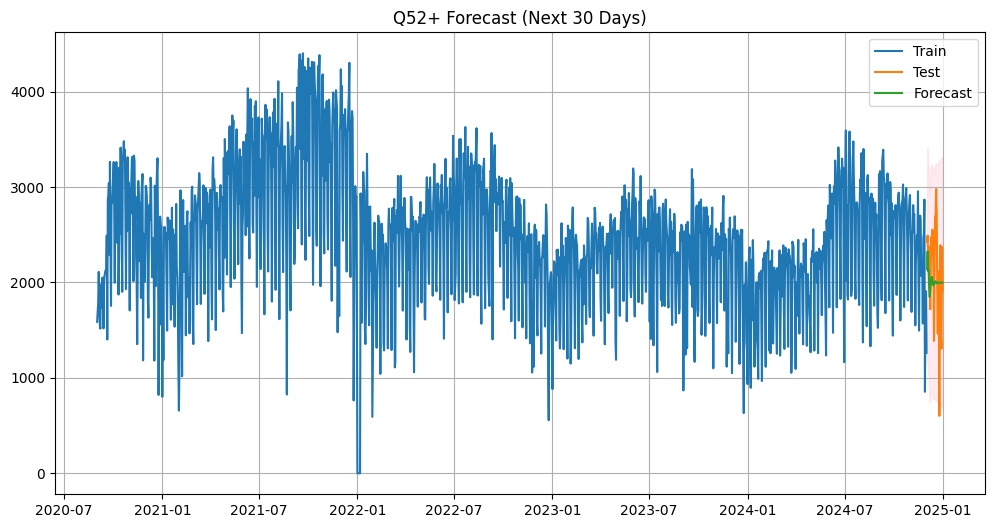

In [19]:
train_q52 = daily_pivot['Q52+'][:-30]
test_q52 = daily_pivot['Q52+'][-30:]

final_model_q52 = SARIMAX(train_q52,
                          order=model_q52.order,
                          enforce_stationarity=False,
                          enforce_invertibility=False).fit(disp=False)

forecast_q52 = final_model_q52.get_forecast(steps=30)
forecast_mean = forecast_q52.predicted_mean
forecast_ci = forecast_q52.conf_int()

plt.figure(figsize=(12,6))
plt.plot(train_q52.index, train_q52, label='Train')
plt.plot(test_q52.index, test_q52, label='Test')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='pink', alpha=0.3)
plt.title('Q52+ Forecast (Next 30 Days)')
plt.legend()
plt.grid()
plt.show()

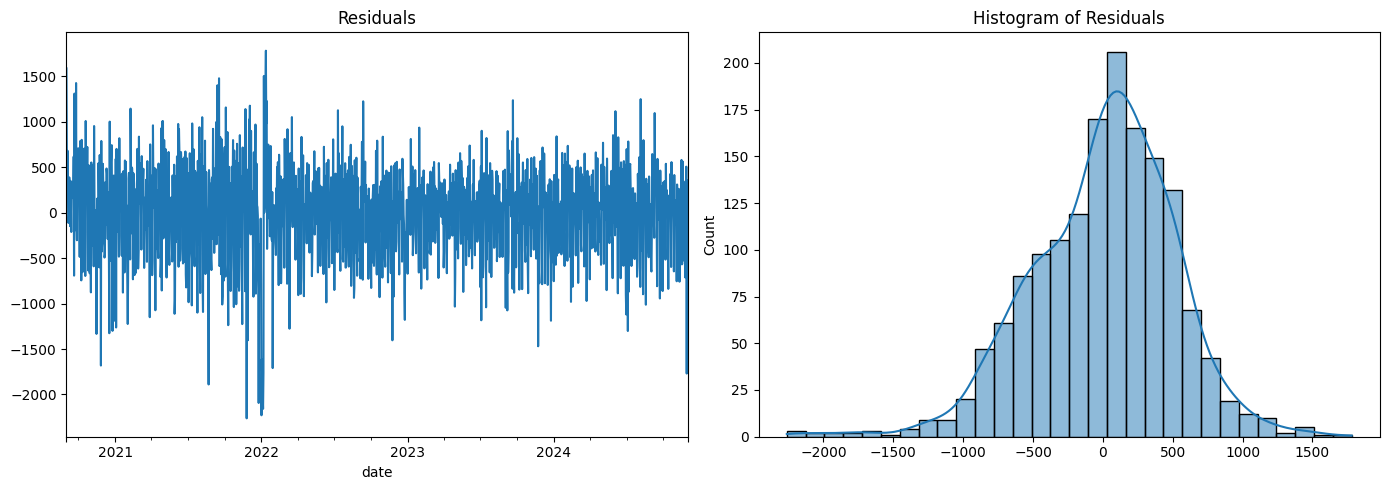

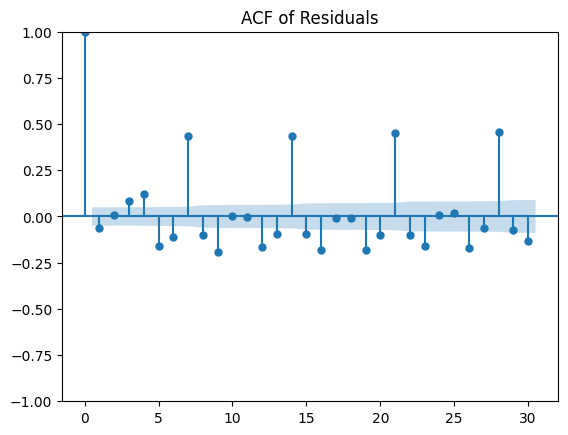

In [20]:
residuals = final_model_q52.resid

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
residuals.plot(title="Residuals", ax=axes[0])
sns.histplot(residuals, bins=30, kde=True, ax=axes[1])
axes[1].set_title("Histogram of Residuals")
plt.tight_layout()
plt.show()

plot_acf(residuals, lags=30)
plt.title("ACF of Residuals")
plt.show()

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test_q52, forecast_mean)
rmse = np.sqrt(mean_squared_error(test_q52, forecast_mean))

print(f"Q52+ Forecast MAE: {mae:.2f}")
print(f"Q52+ Forecast RMSE: {rmse:.2f}")

Q52+ Forecast MAE: 395.51
Q52+ Forecast RMSE: 496.19


In [22]:
q53_diff = daily_pivot['Q53+'].diff().dropna()

run_adf(q53_diff, 'Q53+ (1st diff)')

ADF Test for Q53+ (1st diff)
ADF Statistic: -11.277441431035651
p-value: 1.484518515918916e-20
Critical Values: {'1%': -3.4345487774977768, '5%': -2.8633945067663817, '10%': -2.5677573081032214}
Stationary




In [23]:
# Auto ARIMA (with d=1 expected)
model_q53 = pm.auto_arima(daily_pivot['Q53+'],
                          seasonal=False,
                          trace=True,
                          stepwise=True,
                          suppress_warnings=True,
                          error_action='ignore')

# Summary
model_q53.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=27307.809, Time=5.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=27893.603, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=27841.013, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=27535.381, Time=1.65 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=27891.604, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=27310.056, Time=1.79 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=27286.197, Time=2.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=27364.588, Time=1.49 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=27695.784, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=27274.835, Time=2.86 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=27646.741, Time=0.31 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=27201.948, Time=5.61 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=27571.512, Time=0.49 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=27017.518, Time=2.59 sec
 ARIMA(5,1,0)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1583
Model:               SARIMAX(5, 1, 2)   Log Likelihood              -13371.348
Date:                Wed, 30 Apr 2025   AIC                          26758.695
Time:                        03:48:36   BIC                          26801.627
Sample:                    09-01-2020   HQIC                         26774.646
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4208      0.023     17.968      0.000       0.375       0.467
ar.L2         -0.7276      0.025    -29.486      0.000      -0.776      -0.679
ar.L3         -0.2150      0.030     -7.195      0.000      -0.274      -0.156
ar.L4         -0.3298      0.023    -14.591      0.000      -0.374      -0.285
ar.L5         -0.3334      0.022    -15.204      0.000      -0.376      -0.290
ma.L1         -1.1182      0.015    -75.130      0.000      -1.147      -1.089
ma.L2          0.8598      0.013     68.271      0.000       0.835       0.885
sigma2      1.231e+06   2.84e+04     43.328      0.000    1.17e+06    1.29e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               750.16
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                            -0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

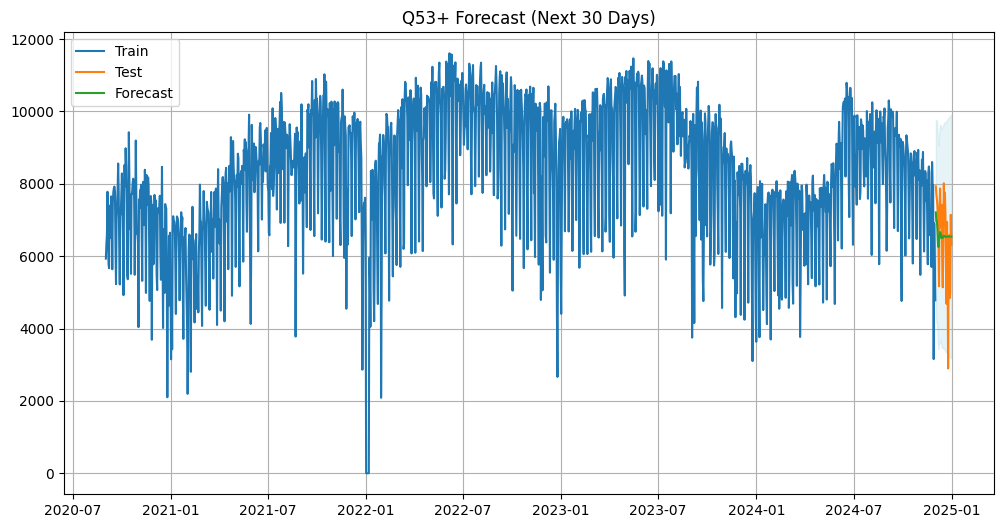

In [24]:
train_q53 = daily_pivot['Q53+'][:-30]
test_q53 = daily_pivot['Q53+'][-30:]

final_model_q53 = SARIMAX(train_q53,
                          order=model_q53.order,
                          enforce_stationarity=False,
                          enforce_invertibility=False).fit(disp=False)

forecast_q53 = final_model_q53.get_forecast(steps=30)
forecast_mean_q53 = forecast_q53.predicted_mean
forecast_ci_q53 = forecast_q53.conf_int()

plt.figure(figsize=(12,6))
plt.plot(train_q53.index, train_q53, label='Train')
plt.plot(test_q53.index, test_q53, label='Test')
plt.plot(forecast_mean_q53.index, forecast_mean_q53, label='Forecast')
plt.fill_between(forecast_ci_q53.index,
                 forecast_ci_q53.iloc[:, 0],
                 forecast_ci_q53.iloc[:, 1],
                 color='lightblue', alpha=0.3)
plt.title('Q53+ Forecast (Next 30 Days)')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
mae_q53 = mean_absolute_error(test_q53, forecast_mean_q53)
rmse_q53 = np.sqrt(mean_squared_error(test_q53, forecast_mean_q53))

print(f"Q53+ Forecast MAE: {mae_q53:.2f}")
print(f"Q53+ Forecast RMSE: {rmse_q53:.2f}")

Q53+ Forecast MAE: 897.39
Q53+ Forecast RMSE: 1134.24


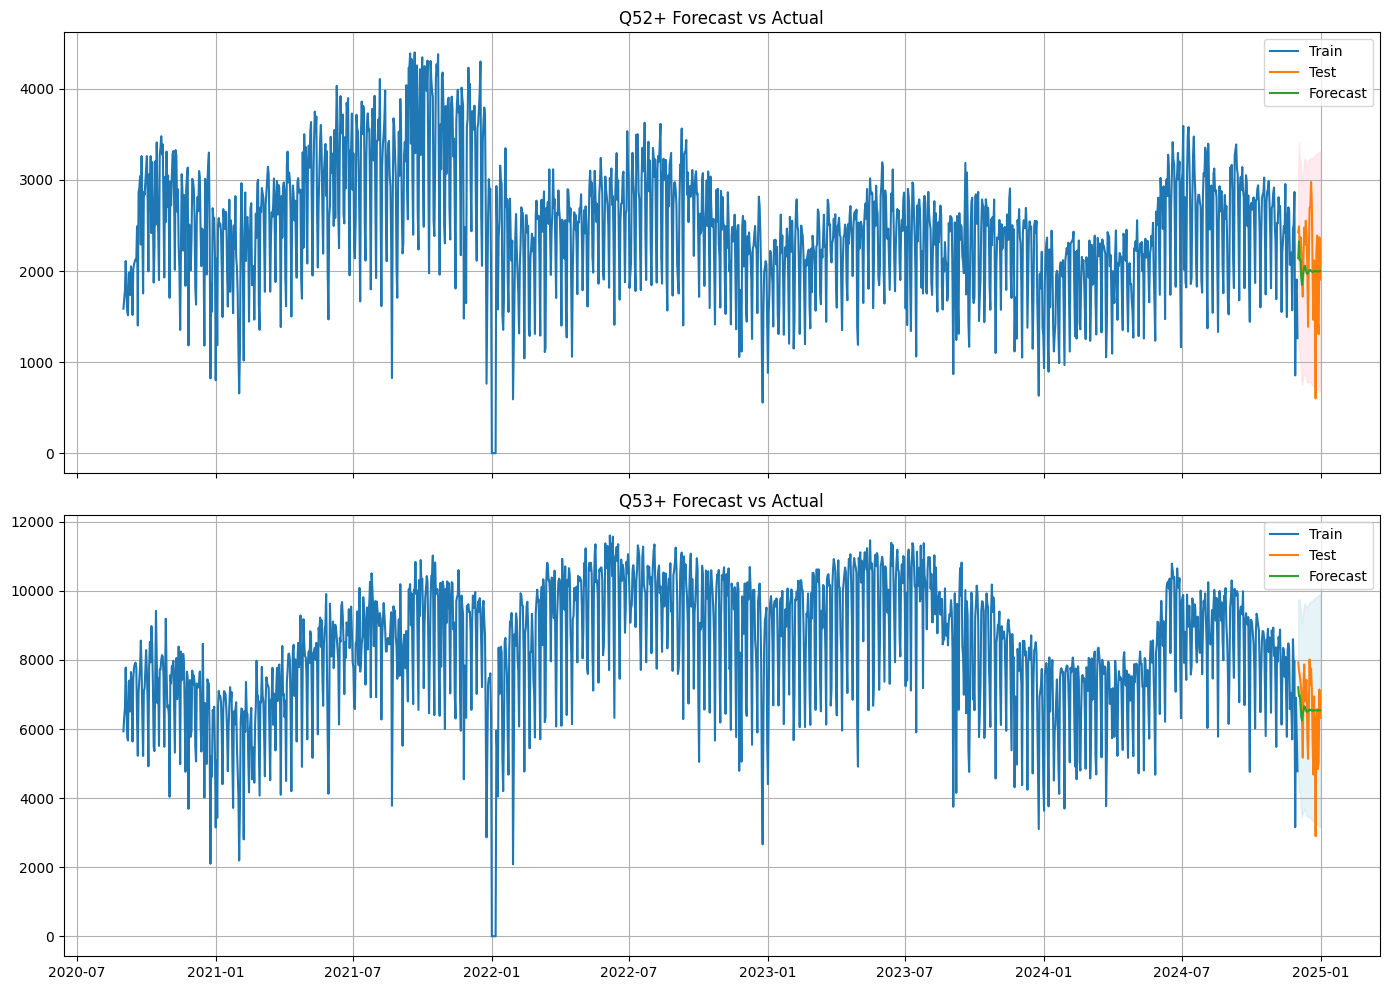

In [26]:
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

axs[0].plot(train_q52.index, train_q52, label='Train')
axs[0].plot(test_q52.index, test_q52, label='Test')
axs[0].plot(forecast_mean.index, forecast_mean, label='Forecast')
axs[0].fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1],
                    color='pink', alpha=0.3)
axs[0].set_title('Q52+ Forecast vs Actual')
axs[0].legend()
axs[0].grid()

axs[1].plot(train_q53.index, train_q53, label='Train')
axs[1].plot(test_q53.index, test_q53, label='Test')
axs[1].plot(forecast_mean_q53.index, forecast_mean_q53, label='Forecast')
axs[1].fill_between(forecast_ci_q53.index, forecast_ci_q53.iloc[:, 0], forecast_ci_q53.iloc[:, 1],
                    color='lightblue', alpha=0.3)
axs[1].set_title('Q53+ Forecast vs Actual')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

### Summary: Time Series Analysis of Q52+ and Q53+ Bus Ridership

We conducted time series forecasting on MTA bus routes Q52+ and Q53+ using ARIMA models, following the methodology taught in CUSP 7023.

**Q52+ Results:**
- Stationarity confirmed without differencing
- Best model: ARIMA(5,1,2)
- Forecast MAE: 395.51 | RMSE: 496.19

**Q53+ Results:**
- Required first-order differencing to achieve stationarity
- Best model: ARIMA(5,1,2)
- Forecast MAE: 897.39 | RMSE: 1134.24

Our models reveal clear seasonality and weekly trends. Q52+ forecasts showed stronger fit and lower error compared to Q53+. The higher variance in Q53+ ridership likely contributed to greater forecast uncertainty.

These forecasts provide a baseline for simulating the impact of the proposed QueensLink subway expansion, which is expected to shift ridership from these bus routes to rail.